In [32]:
from __future__ import division

import os
import matplotlib.pyplot as plt
import numpy as np
import skbio
import scipy.stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

import absloute_power.traditional as trad
import absloute_power.utils as ap


import pandas as pd
import biom

from skbio.stats.power import subsample_power

from absloute_power.traditional import calc_ttest_1

import pickle

In [11]:
base_dir = '/Users/jwdebelius/Repositories/Absloute-Power'
data_dir = os.path.join(base_dir, 'data/otu_table_and_mapping_ibd')
map_fp = os.path.join(data_dir, 'merged_mapping_file_raw__BODY_SITE_feces__.txt')
otu_fp = os.path.join(data_dir, 'merged_otu_table_IBD_only_feces_1k__BODY_SITE_feces__.biom')
uud_fp = os.path.join(data_dir, '1k/unweighted_unifrac_dm.txt')

In [59]:
map_ = pd.read_csv(map_fp, sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)
uud = skbio.DistanceMatrix.read(uud_fp)

In [13]:
def test_beta_permanova(ids, meta, dm, cat, num_iter=99):
    """Tests difference in beta diversity for a category and distance matrix"""
    # Gets the map and distance matrix subset
    all_ids = np.hstack(ids)
    # Calculates the permanova
    perma_results = skbio.stats.distance.permanova(dm.filter(all_ids), 
                                                   meta.loc[all_ids],
                                                   cat,
                                                   num_iter)
    # Returns the p value
    return perma_results['p-value']

In [14]:
map_.columns

Index([u'BarcodeSequence', u'LinkerPrimerSequence', u'IBD_CAT_META',
       u'DIAGNOSIS', u'DIAGNOSIS_2', u'DISEASE_STAT', u'SAMPLE_TYPE',
       u'IBD_TYPE', u'ULCERATIVE_COLIT_OR_CROHNS_DIS', u'DISEASE_STATUS',
       u'DISEASE_STAT2', u'IBD', u'AGE', u'CD_RESECTION', u'BODY_SITE',
       u'COUNTRY', u'BMI', u'SAMPLE_CENTER', u'SMOKING_STATUS', u'TITLE',
       u'AB_TYPE', u'AB', u'ABX', u'SEX', u'sex', u'ETHNICITY', u'RACE',
       u'STUDY_CENTER', u'PLATFORM', u'STEROIDS', u'STUDY_ID', u'RUN_CENTER',
       u'Description'],
      dtype='object')

In [15]:
map_.groupby('DIAGNOSIS_2').count().max(1)

DIAGNOSIS_2
Crohns                259
Healthy               122
IBD undefined           1
Ulcerative Colitis    267
dtype: int64

In [16]:
map_.groupby('IBD_TYPE').count().max(1)

IBD_TYPE
CCD    111
HC     122
ICD    148
UC     267
dtype: int64

In [10]:
map_.loc[map_.DIAGNOSIS_2 == 'IBD undefined', 'DIAGNOSIS_2'] = np.nan
map_.loc[map_.STUDY_ID == '966', 'STUDY_ID'] = np.nan

In [11]:
study_test = lambda x: test_beta_permanova(x, map_, uud, 'STUDY_ID')
ibd_test = lambda x: test_beta_permanova(x, map_, uud, 'DIAGNOSIS_2')

In [17]:
inter_ids = list(set(map_.index).intersection(set(uud.ids)))

In [13]:
study_ids = [ids for ids in map_.loc[inter_ids].groupby('STUDY_ID').groups.itervalues()]
ibd_ids = [ids for ids in map_.loc[inter_ids].groupby('DIAGNOSIS_2').groups.itervalues()]

In [19]:
type_test = lambda x: test_beta_permanova(x, map_, uud, 'IBD_TYPE')

In [35]:
ibd_test(ibd_ids)

0.001

In [17]:
study_power, study_counts = subsample_power(study_test, 
                                            study_ids, 
                                            min_counts=3, 
                                            max_counts=15, 
                                            alpha_pwr=0.02,
                                            counts_interval=1)

In [18]:
ibd_power, ibd_counts = subsample_power(ibd_test, 
                                            ibd_ids, 
                                            min_counts=5, 
                                            max_counts=25, 
                                            alpha_pwr=0.02,
                                            counts_interval=2)

In [24]:
print np.round(np.nanmean(ap.z_effect(ibd_counts, ibd_power, 0.02)), 3)
np.round(np.nanstd(ap.z_effect(ibd_counts, ibd_power)) / np.sqrt(np.prod(ibd_power.shape)) * scipy.stats.t.ppf(0.975, np.prod(ibd_power.shape)-1), 3)

1.218


0.035000000000000003

In [ ]:
print np.round(np.nanmean(ap.z_effect(ibd_counts, ibd_power, 0.02)), 3)
np.round(np.nanstd(ap.z_effect(ibd_counts, ibd_power)) / np.sqrt(np.prod(ibd_power.shape)) * scipy.stats.t.ppf(0.975, np.prod(ibd_power.shape)-1), 3)

### ids

In [26]:
import pickle
with open(os.path.join(data_dir, 'ibd.p'), 'wb') as f_:
    pickle.dump([study_power, study_counts, ibd_power, ibd_counts], f_)

In [28]:
os.path.join(data_dir, 'ibd.p')

'/Users/jwdebelius/Repositories/Absloute-Power/data/otu_table_and_mapping_ibd/ibd.p'

<Container object of 3 artists>

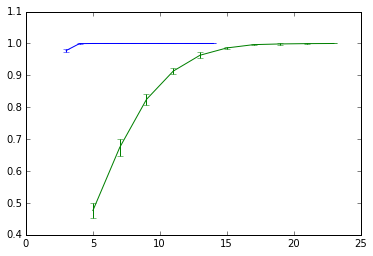

In [38]:
%matplotlib inline
plt.errorbar(study_counts, study_power.mean(0), yerr=study_power.std(0) / np.sqrt())
plt.errorbar(ibd_counts, ibd_power.mean(0), yerr=ibd_power.std(0))
# plt.plot(np.arange(1, 15, 0.5), ap.z_power(np.arange(1, 15, 0.5), baby_eff))
# plt.fill_between(np.arange(1, 15, 0.5), 
#                  ap.z_power(np.arange(1, 15, 0.5), baby_eff - baby_sem),
#                  ap.z_power(np.arange(1, 15, 0.5), baby_eff + baby_sem))

In [39]:
study_power.shape

(10, 12)

In [21]:
ibd_type_groups = map_.loc[inter_ids].groupby('IBD_TYPE').groups
type_ids = [ids for ids in ibd_type_groups.itervalues()]

hc_cc_ids = [ibd_type_groups[g] for g in ['HC', 'CCD']]
hc_ic_ids = [ibd_type_groups[g] for g in ['HC', 'ICD']]
hc_uc_ids = [ibd_type_groups[g] for g in ['HC', 'UC']]
cc_ic_ids = [ibd_type_groups[g] for g in ['CCD', 'ICD']]
cc_uc_ids = [ibd_type_groups[g] for g in ['CCD', 'UC']]
ic_uc_ids = [ibd_type_groups[g] for g in ['ICD', 'UC']]



In [22]:
type_test = lambda x: test_beta_permanova(x, map_, uud, 'IBD_TYPE')

In [24]:
type_power, type_counts = subsample_power(type_test, 
                                            type_ids, 
                                            min_counts=5, 
                                            max_counts=25, 
                                            alpha_pwr=0.02,
                                            counts_interval=3)

In [27]:
eff = ap.z_effect(type_counts, type_power)
print 'all types', np.nanmean(eff), np.nanstd(eff) / np.sqrt(len(eff)) * scipy.stats.t.ppf(0.975, len(eff) - 1)

all types 1.54300273639 0.0585478091639


In [28]:
hc_cc_power, hc_cc_counts = subsample_power(type_test, 
                                            hc_cc_ids, 
                                            min_counts=5, 
                                            max_counts=25, 
                                            alpha_pwr=0.02,
                                            counts_interval=3)

In [29]:
hc_cc_power, hc_cc_counts = subsample_power(type_test, hc_cc_ids, min_counts=5, max_counts=25, alpha_pwr=0.02, counts_interval=3)
hc_ic_power, hc_ic_counts = subsample_power(type_test, hc_ic_ids, min_counts=5, max_counts=25, alpha_pwr=0.02, counts_interval=3)
hc_uc_power, hc_uc_counts = subsample_power(type_test, hc_uc_ids, min_counts=5, max_counts=25, alpha_pwr=0.02, counts_interval=3)
cc_ic_power, cc_ic_counts = subsample_power(type_test, cc_ic_ids, min_counts=5, max_counts=25, alpha_pwr=0.02, counts_interval=3)
cc_uc_power, cc_uc_counts = subsample_power(type_test, cc_uc_ids, min_counts=5, max_counts=25, alpha_pwr=0.02, counts_interval=3)
ic_uc_power, ic_uc_counts = subsample_power(type_test, ic_uc_ids, min_counts=5, max_counts=25, alpha_pwr=0.02, counts_interval=3)

In [30]:
type_ = {'all_types': (type_power, type_counts, type_test(type_ids)),
         ('hc', 'cc'): (hc_cc_power, hc_cc_counts, type_test(hc_cc_ids)),
         ('hc', 'ic'): (hc_ic_power, hc_ic_counts, type_test(hc_ic_ids)),
         ('hc', 'uc'): (hc_uc_power, hc_uc_counts, type_test(hc_uc_ids)),
         ('cc', 'ic'): (cc_ic_power, cc_ic_counts, type_test(cc_ic_ids)),
         ('cc', 'uc'): (cc_uc_power, cc_uc_counts, type_test(cc_uc_ids)),
         ('ic', 'uc'): (ic_uc_power, ic_uc_counts, type_test(ic_uc_ids))
        }

In [33]:
with open(os.path.join(data_dir, 'ibd_type.p'), 'wb') as f_:
    pickle.dump(type_, f_)

In [37]:
for k, (pwr, cnt, p) in type_.iteritems():
    eff = ap.z_effect(cnt, pwr, 0.02)
    n = np.sum(np.isnan(eff) == False)
    m = np.nanmean(eff)
    s = np.nanstd(eff) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1)
    
    print k, np.round(m, 2), '[', np.round(m-s, 2), ', ', np.round(m+s, 2), ']'

('hc', 'uc') 0.61 [ 0.57 ,  0.64 ]
all_types 1.72 [ 1.67 ,  1.77 ]
('hc', 'ic') 1.56 [ 1.47 ,  1.65 ]
('cc', 'uc') 0.27 [ 0.24 ,  0.29 ]
('ic', 'uc') 1.2 [ 1.15 ,  1.25 ]
('hc', 'cc') 0.64 [ 0.6 ,  0.68 ]
('cc', 'ic') 1.16 [ 1.11 ,  1.2 ]


In [40]:
map_.groupby('BODY_SITE').count().max(1)

BODY_SITE
UBERON:feces    649
dtype: int64

In [42]:
map_.shape

(649, 33)

In [43]:
map_.columns

Index([u'BarcodeSequence', u'LinkerPrimerSequence', u'IBD_CAT_META',
       u'DIAGNOSIS', u'DIAGNOSIS_2', u'DISEASE_STAT', u'SAMPLE_TYPE',
       u'IBD_TYPE', u'ULCERATIVE_COLIT_OR_CROHNS_DIS', u'DISEASE_STATUS',
       u'DISEASE_STAT2', u'IBD', u'AGE', u'CD_RESECTION', u'BODY_SITE',
       u'COUNTRY', u'BMI', u'SAMPLE_CENTER', u'SMOKING_STATUS', u'TITLE',
       u'AB_TYPE', u'AB', u'ABX', u'SEX', u'sex', u'ETHNICITY', u'RACE',
       u'STUDY_CENTER', u'PLATFORM', u'STEROIDS', u'STUDY_ID', u'RUN_CENTER',
       u'Description'],
      dtype='object')

In [45]:
map_.AGE.min()

'10'

In [62]:
map_.groupby('AGE').count().max(1)

AGE
10           3
11           5
12           7
13           6
14          10
15           5
16           6
17           4
18           4
19           5
20           3
21           1
22           1
23           4
24           5
25           1
26           3
29           1
31           4
38           2
4            3
43           2
44           2
46           2
5            5
50           1
51           2
52           2
53           3
54           5
55           3
57           2
6            1
60           3
61           4
62           4
65           1
67           1
68           1
69           1
70           1
71           4
72           2
8            2
9            4
None        23
no_data    485
dtype: int64

In [63]:
def convert_age(x):
    if x in {'no_data', 'None', None}:
        return np.nan
    else:
        return float(int(x))
    
map_.AGE = map_.AGE.apply(convert_age)

In [66]:
map_.AGE.min(), map_.AGE.max(), map_.AGE.mean(), map_.AGE.std() / np.sqrt(len(map_.AGE))

(4.0, 72.0, 29.815602836879432, 0.8297198426702237)

In [57]:
map_.sort('AGE').loc[map_.AGE.apply(lambda x: np.isnan(x) == False), 'AGE']

TypeError: Not implemented for this type